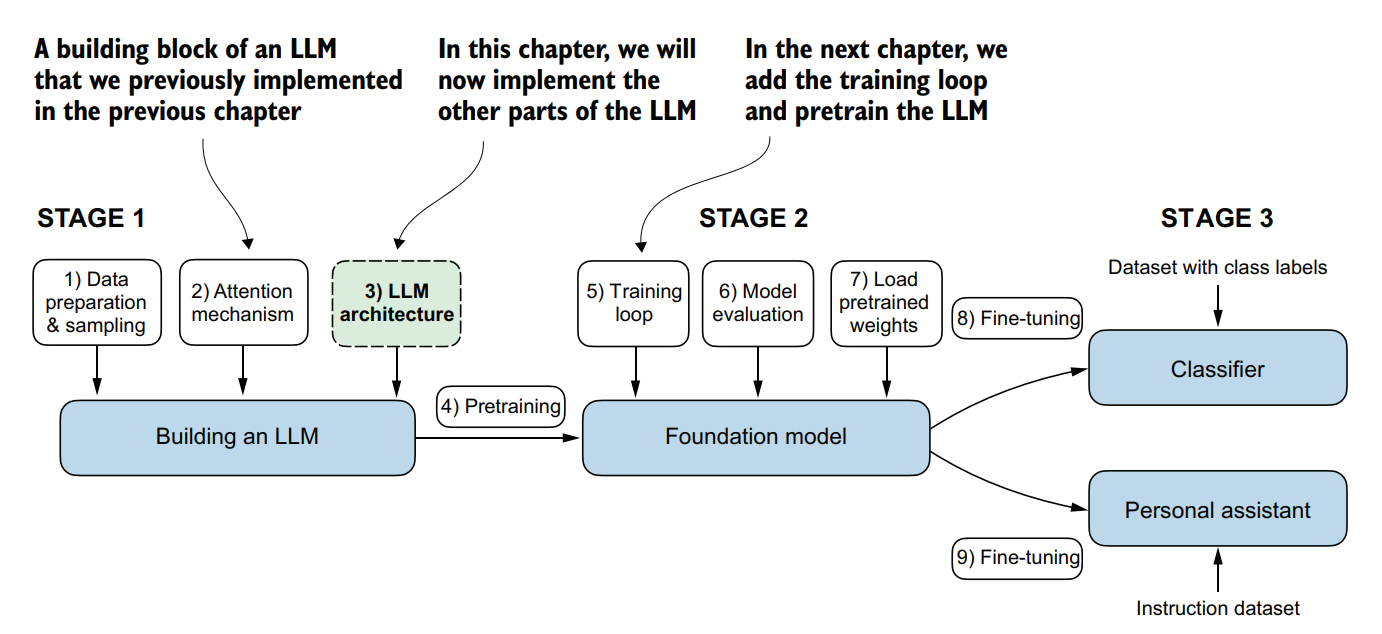

### 4.1. Coding an LLM architecture

Before, let's explore the architecture of a small GPT model


In [349]:
GPT_CONFIG_124M = {
    "vocab_size" :50257,
    "context_length":1024,
    "emb_dim": 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias": False

}

In [350]:
import torch
import torch.nn as nn

In [351]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_em     = nn.Embedding(cfg["vocab_size"]    , cfg["emb_dim"])
        self.pos_em     = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb   = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range (cfg["n_layers"])] ## Placeholder for transformer blocks
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head   = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_em(in_idx)
        pos_embeds = self.pos_em(
            torch.arange(seq_len,device = in_idx.device)
        )
        x = tok_embeds+pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        print(x.shape)
        x = self.final_norm(x)
        print(x.shape)
        logits = self.out_head(x)
        print(logits.shape)
        return logits

class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    def forward(self,x):
        return x
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
    def forward(self, x):
        return x

In [352]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day hold a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 1745,  257]])


In [353]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
print("batch shape:" ,batch.shape)
logits = model(batch)
print(logits)

batch shape: torch.Size([2, 4])
torch.Size([2, 4, 768])
torch.Size([2, 4, 768])
torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [-0.0063,  0.6248, -0.0776,  ...,  0.7499,  0.4245, -1.0798],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


#### Normalizing activations with layer normalization

In [354]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.esp = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    def forward(self,x:torch.Tensor):
        mean = x.mean(dim = -1, keepdim = True)
        var  = x.var(dim=-1, keepdim=True,unbiased=False)
        norm_x = (x-mean)/torch.sqrt(var+self.esp)
        return self.scale*norm_x+self.shift

#### Implementing a feed forward network with GELU activations


In [355]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x:torch.Tensor):
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))

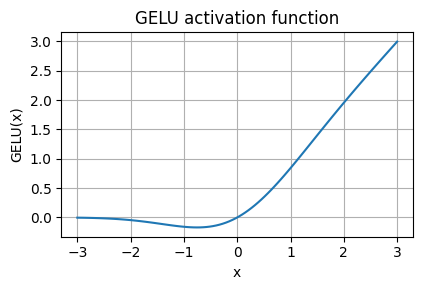

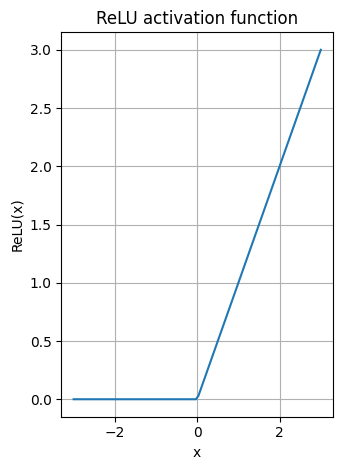

In [356]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [357]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
        )
    def forward(self,x):
        return self.layers(x)

In [358]:
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([ 
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
              GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
              GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
              GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
              GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
              GELU())
            ])
  def forward(self, x):
    for layer in self.layers:   
      layer_output = layer(x)
      if self.use_shortcut and x.shape == layer_output.shape:
          x = x + layer_output
      else:
          x = layer_output
    return x

In [359]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
filter = nn.Linear(3,3)
print(filter(sample_input))
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
def print_gradients(model, x):
    output = model(x)
    print(output)
    target = torch.tensor([[0.]])
    loss   = nn.MSELoss()
    loss   = loss(output, target)
    loss.backward() 
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            
print_gradients(model_without_shortcut, sample_input)

tensor([[-0.1906,  0.2981, -0.8049]], grad_fn=<AddmmBackward0>)
tensor([[0.0610]], grad_fn=<MulBackward0>)
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


In [360]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_without_shortcut, sample_input)

tensor([[0.7669]], grad_fn=<MulBackward0>)
layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


#### 4.5 Connecting attention and linear layers in a transformer block


In [361]:
class MuitiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert(d_out % d_in == 0), "Problem with head dim"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim     = d_out//num_heads
        self.W_q          = nn.Linear(d_in , d_out, bias=qkv_bias)
        self.W_k          = nn.Linear(d_in , d_out, bias=qkv_bias)
        self.W_v          = nn.Linear(d_in , d_out, bias=qkv_bias)
        self.out_project  = nn.Linear(d_out, d_out)
        self.dropout      = nn.Dropout(p=dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length,context_length), diagonal=1))
        
    def forward(self,x):
        batch_size, num_tokens, d_in = x.shape
        keys                         = self.W_k(x)
        queries                      = self.W_q(x)
        values                       = self.W_v(x)
        keys                         = keys   .view(batch_size, num_tokens, self.num_heads, self.head_dim)
        queries                      = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values                       = values .view(batch_size, num_tokens, self.num_heads, self.head_dim)
        keys                         = keys.transpose(1,2)
        queries                      = queries.transpose(1,2)
        values                       = values.transpose(1, 2)
        attention_scores             = queries@keys.transpose(2,3)
        mask_bool                    = self.mask.bool()[:num_tokens,:num_tokens]
        attention_scores.masked_fill_(mask_bool, -torch.inf)
        attention_weights            = torch.softmax(attention_scores/keys.shape[-1]**0.5, dim = -1)
        attention_weights            = self.dropout(attention_weights)
        context_vec                  = (attention_weights@values).transpose(1,2)
        context_vec  = context_vec.contiguous().view(
            batch_size, num_tokens, self.d_out
        )
        context_vec = self.out_project(context_vec)
        return context_vec

In [362]:
class TransofmerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MuitiheadAttention(
            d_in = cfg["emb_dim"],
            d_out= cfg["emb_dim"],
            context_length = cfg["context_length"],
            num_heads      = cfg["n_heads"],
            dropout        = cfg["drop_rate"],
            qkv_bias       = cfg["qkv_bias"])
        self.ff    = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    
    def forward(self,x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [363]:
GPT_CONFIG_124M = {
    "vocab_size" :50257,
    "context_length":1024,
    "emb_dim": 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias": False

}

In [364]:
torch.manual_seed(123)
x= torch.rand(2,4,768)
print(x.shape)
block = TransofmerBlock(GPT_CONFIG_124M)
output = block(x)
print(output.shape)

torch.Size([2, 4, 768])
torch.Size([2, 4, 768])


In [365]:
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 1745,  257]])


In [366]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb    = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb    = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb   = nn.Dropout(cfg["drop_rate"])
        self.tran_block = nn.Sequential(
            *[TransofmerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head   = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    def forward(self, input):
        batch, sequen = input.shape
        tok_embds     = self.tok_emb(input)
        pos_embds     = self.pos_emb(torch.arange(sequen,device=input.device))
        x             = tok_embds + pos_embds 
        x             = self.drop_emb(x)
        x             = self.tran_block(x)
        x             = self.final_norm(x)
        y             = self.out_head(x)
        return y   
   

In [367]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 1745,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 1.4994, -0.4687, -0.5944,  ...,  0.3083, -0.0415, -0.0686],
         [ 0.0385, -0.1492,  0.5131,  ...,  1.2035, -0.4707, -0.0221]]],
       grad_fn=<UnsafeViewBackward0>)


In [368]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [ ]:
def generate_text_simple(model, idx,max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:, -1, :]
            probas = torch.softmax(logits, dim=-1)
            idx_next = torch.argmax(probas, dim=-1, keepdim=True)
            idx = torch.cat((idx, idx_next), dim=1)
    return idx


In [370]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [371]:
model.eval()
out = generate_text_simple(
 model=model,
 idx=encoded_tensor,
 max_new_tokens=6,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [372]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue
